In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import copy
from football_sim.all import Calibrator, Season,Settings
%matplotlib inline
import platform

In [2]:
base_dir = './'

settings = Settings(os.path.join(base_dir, 'config.yaml'))

In [3]:
calib = Calibrator(settings)
calib.download_all_data() 
calib.process_data()

In [4]:
year = 2020
league = 'BPL'
as_of=pd.to_datetime('2020-01-01')
as_of=None
calib.calibrate_teams(league,year,as_of=as_of)

In [5]:
season = Season(league, year,calib, use_home_advantage=False,as_of=as_of)
print('home advantage', season.home_advantage)

season.process_current_results()
season.simulate_season(n_scenarios=100000)

season.process_simulation()

home advantage 1


In [6]:

ind=None
i=season.match_id['bpl_burnley_manchesterunited_2021-01-12']
hg=season.simulated_home_goals[i,:]
ag=season.simulated_away_goals[i,:]
ind=ag>hg
i=season.match_id['bpl_liverpool_manchesterunited_2021-01-17']
#ind=None
hg=season.simulated_home_goals[i,:]
ag=season.simulated_away_goals[i,:]
ind = ind&(ag>=hg)
print(100*ind.sum()/ind.size)
# ind= None
#i = season.team_id['Manchester United']
#ind = season.place_per_team[i,:]<=4
ind = None
sr=season.season_report(ind=ind)
sr

27.671


,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,rating,Degr
Manchester City,15,29,77.8,68,87,4,1,59.53,97.48,5.62,0.25,22.268719,0.00
Liverpool,17,33,74.1,65,83,5,1,28.91,92.32,5.49,0.30,18.025326,0.00
Manchester United,16,33,68.5,59,78,8,1,6.66,65.33,4.50,0.35,12.899341,0.00
Leicester City,17,32,64.3,55,74,10,2,1.58,37.07,3.97,0.32,12.282768,0.00
Tottenham Hotspur,16,29,63.4,53,73,11,2,1.37,33.95,4.24,0.35,12.049250,0.00
Chelsea,17,26,62.2,52,72,11,3,0.88,27.32,4.62,0.32,14.495335,0.00
Aston Villa,15,26,60.7,51,71,12,3,0.62,19.98,4.28,0.36,11.912785,0.00
Everton,16,29,59.8,50,70,12,3,0.34,13.71,3.84,0.35,10.852779,0.00
Southampton,17,29,56.3,47,66,13,5,0.06,4.98,3.38,0.36,9.524454,0.02
West Ham United,17,26,56.0,46,66,14,5,0.03,4.39,3.77,0.37,10.331882,0.05


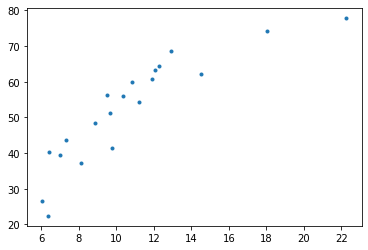

In [7]:
plt.plot(sr['rating'],sr['Points (mean)'],'.')

Chelsea
Leicester City
Liverpool
Manchester City
Manchester United
Tottenham Hotspur


Text(0.5, 0, 'def')

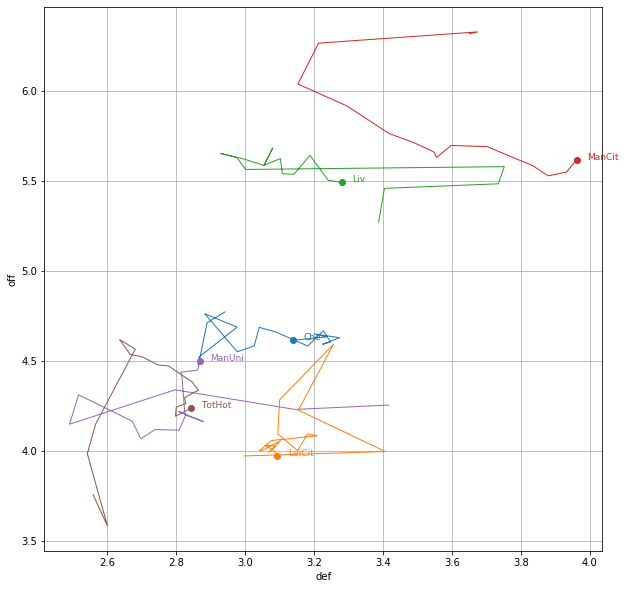

In [8]:
team_names = list(season.teams.keys())
y=[season.teams[x].offense for x in team_names]
x=[1/season.teams[x].defense for x in team_names]
plt.figure(figsize=(10,10))
#plt.plot(x,y,'.')
c=0
for x_,y_,name in zip(x,y,team_names):
    team = season.teams[name]
    if dict(sr['CL'])[name]>20:
        print(name)
        if c<=9:
            sym='-'
        else:
            sym='-'
        p=plt.plot(1/np.array(team.defense_hist),team.offense_hist,sym,label=name,color='C{:d}'.format(c),linewidth=1)
        c+=1
        plt.plot(x_,y_,'o',color=p[0].get_color())
        name_=''.join([x[:3] for x in name.split()])
        plt.text(x_+0.03,y_,name_,fontsize=9,color=p[0].get_color())
plt.grid(True)
plt.ylabel('off')
plt.xlabel('def')
#plt.legend()

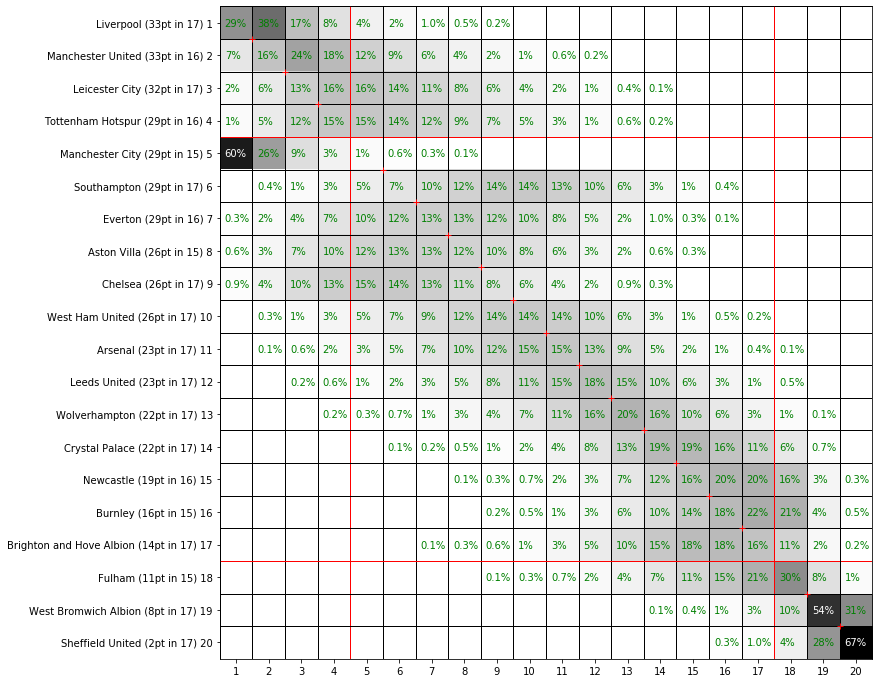

In [9]:
season.probability_grid(ind=ind);

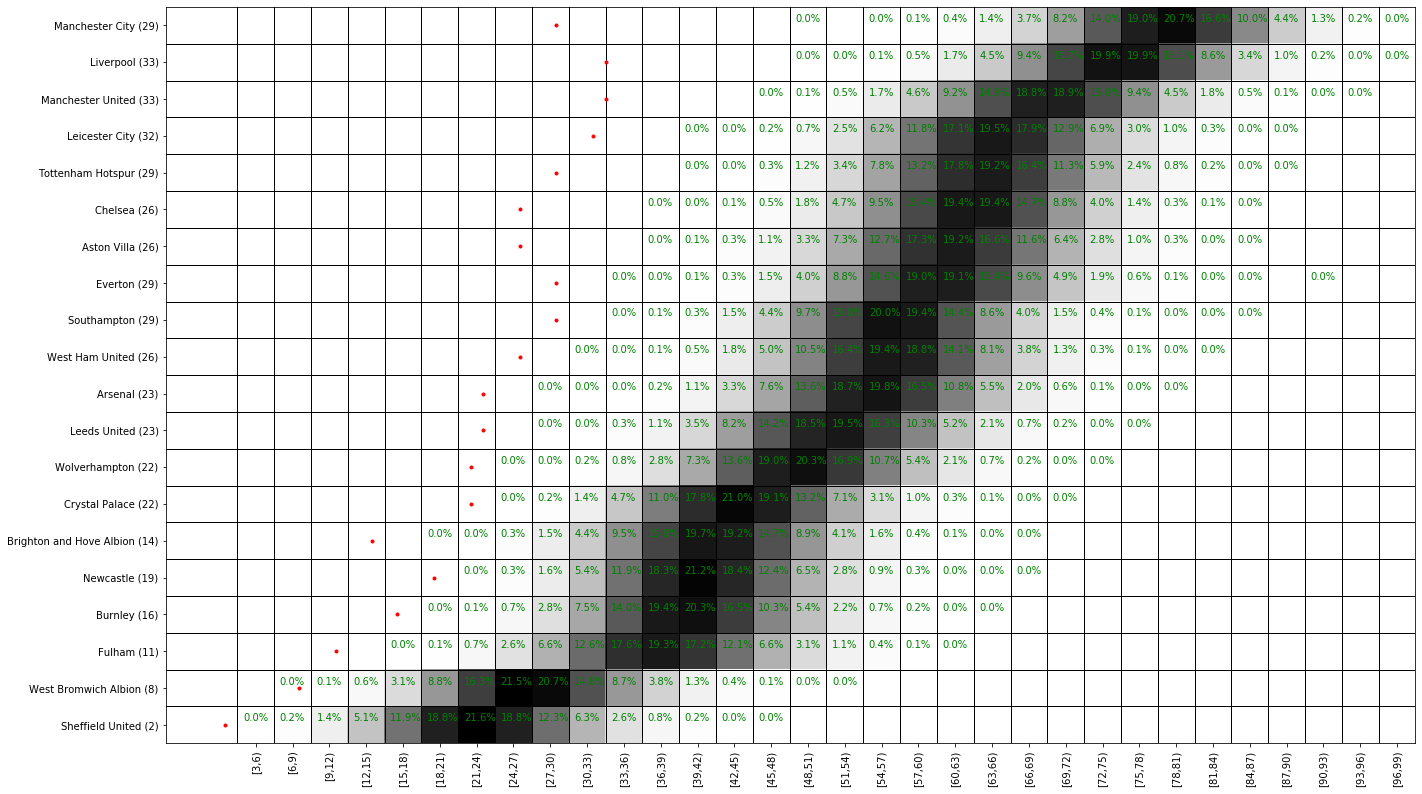

In [10]:
season.points_probability_grid(ind=ind);

In [11]:
my_team = season.teams['Manchester United']

"""names = []
importance = []
home=[]
away=[]

for m in season.matches_to_sim:
    #p=season.importance(m,ref_team=my_team,place=4,or_better=True)
    names.append(m.id)
    #importance.append(np.sum((p[1:]-p[0])**2))
    importance.append(season.importance(m,ref_team=my_team,place=4,or_better=True))
    home.append(m.home_team_name)
    away.append(m.away_team_name)

names=np.array(names)
importance=np.array(importance)

isort = np.argsort(-importance)
names=names[isort]
importance=importance[isort]
season.team_report(my_team,places=[1,2,3,4])

#matches_to_report = [m for m in season.matches_to_sim if 'manchesterunited' in m.id]"""
matches_to_report = [m for m in season.matches_to_sim ]

df = pd.DataFrame({'date':[m.date for m in matches_to_report],
                   'id':[m.id for m in matches_to_report],
                   'home':[m.home_team_name for m in matches_to_report],
                   'away':[m.away_team_name for m in matches_to_report],
              'home win':[m.forecast_home_wins for m in matches_to_report],
             'away win':[m.forecast_away_wins for m in matches_to_report],
             'draw':[m.forecast_draw for m in matches_to_report],
            'home goals':[m.forecast_home_goals for m in matches_to_report],
             'away goals':[m.forecast_away_goals for m in matches_to_report],
             'importance':[100*season.importance(m,ref_team=my_team,place=4,or_better=True) for m in matches_to_report]})

#df.sort_values(by='importance',ascending=False)
df['importance']=(df['importance']-df['importance'].min())/(df['importance'].max()-df['importance'].min())
df.sort_values(by='importance',ascending=False)


,date,id,home,away,home win,away win,draw,home goals,away goals,importance
71,2021-02-13,bpl_westbromwichalbion_manchesterunited_2021-0...,West Bromwich Albion,Manchester United,16.248,65.128,18.624,1.08868,2.33032,1.000000
187,2021-05-11,bpl_manchesterunited_leicestercity_2021-05-11,Manchester United,Leicester City,39.026,35.864,25.110,1.45379,1.38428,0.941127
32,2021-01-27,bpl_manchesterunited_sheffieldunited_2021-01-27,Manchester United,Sheffield United,58.414,17.866,23.720,1.74294,0.85488,0.920826
136,2021-04-10,bpl_tottenhamhotspur_manchesterunited_2021-04-10,Tottenham Hotspur,Manchester United,35.940,40.142,23.918,1.48374,1.58144,0.903249
22,2021-01-20,bpl_fulham_manchesterunited_2021-01-20,Fulham,Manchester United,23.775,54.911,21.314,1.28564,2.04528,0.857209
...,...,...,...,...,...,...,...,...,...,...
56,2021-02-06,bpl_leedsunited_crystalpalace_2021-02-06,Leeds United,Crystal Palace,48.759,29.093,22.148,1.92046,1.44512,0.000041
14,2021-01-16,bpl_leedsunited_brightonandhovealbion_2021-01-16,Leeds United,Brighton and Hove Albion,38.673,39.372,21.955,1.77815,1.79299,0.000034
52,2021-02-02,bpl_sheffieldunited_westbromwichalbion_2021-02-02,Sheffield United,West Bromwich Albion,38.126,34.926,26.948,1.27545,1.20928,0.000032
69,2021-02-13,bpl_crystalpalace_burnley_2021-02-13,Crystal Palace,Burnley,36.696,34.175,29.129,1.13004,1.07731,0.000009


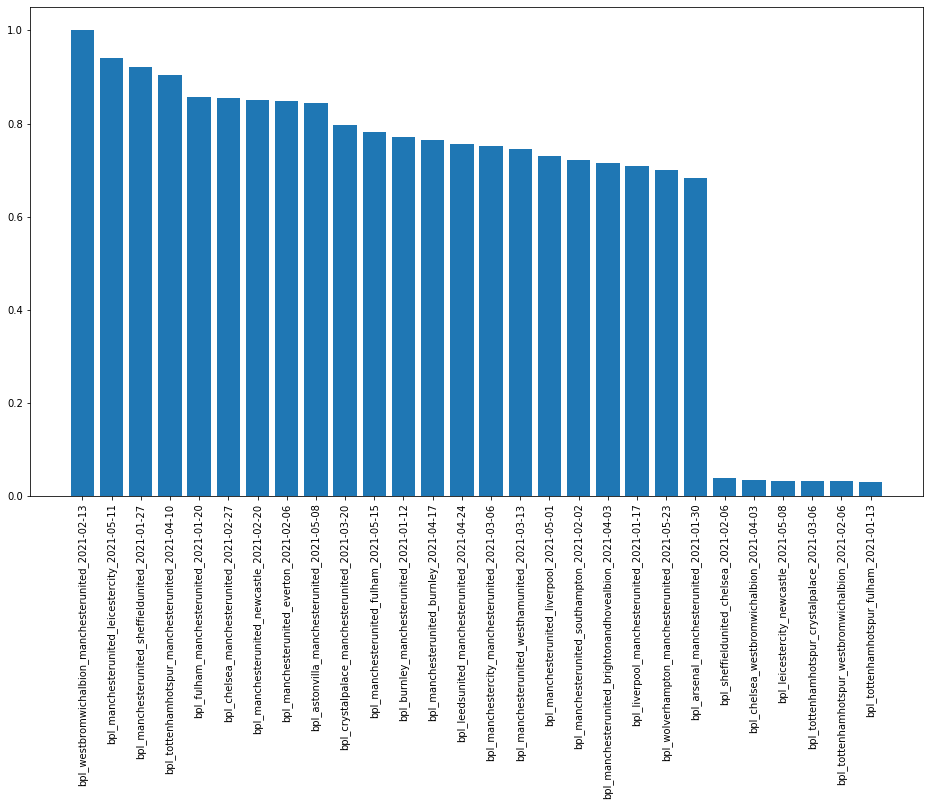

In [12]:
n_plot=28

plt.figure(figsize=(16,9))
df2=df.sort_values(by='importance',ascending=False).head(n_plot).copy()
plt.bar(np.arange(n_plot),df2['importance'].values)
plt.xticks(np.arange(n_plot),df2['id'].values,rotation=90);

(array([65.331     , 55.74012243, 74.90159932, 63.68007358]),
 <Figure size 1152x648 with 1 Axes>)

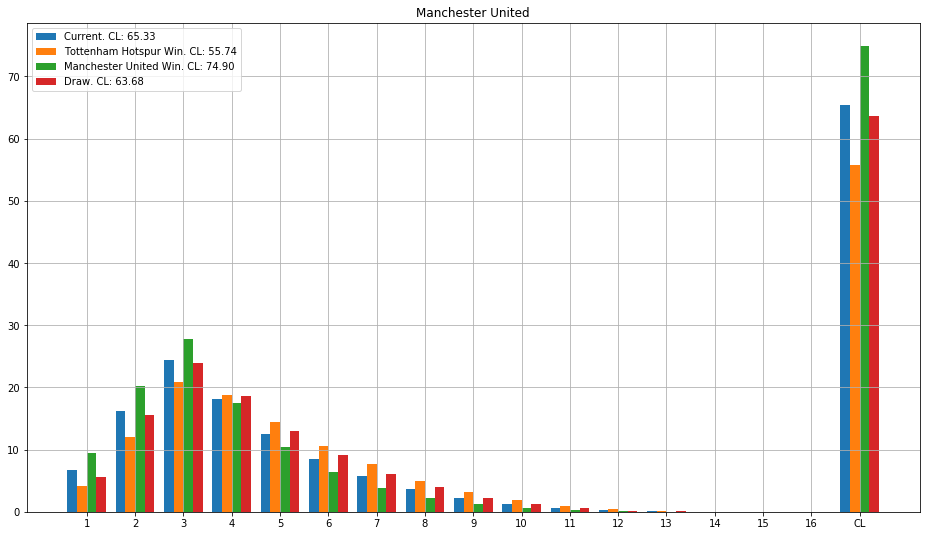

In [13]:
i=season.match_id['bpl_tottenhamhotspur_manchesterunited_2021-04-10']
match = season.matches_to_sim[i]
mufc = season.teams['Manchester United']
#wh = season.teams['West Ham United']
season.what_if(match,ref_team=mufc,place=4,or_better=True)

D:\Miniconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


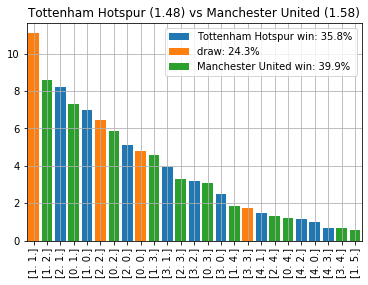

In [14]:
match.home_team.outcomes_vs(match.away_team)

In [15]:
home_team=match.home_team
away_team=match.away_team
if home_team.name == 'Manchester United':
    print('home')
    l_mu=home_team.offense*away_team.defense/90
    l_other=home_team.defense*away_team.offense/90
    other_team_name = away_team.name
elif away_team.name == 'Manchester United':
    print('away')
    l_mu=home_team.defense*away_team.offense/90
    l_other=home_team.offense*away_team.defense/90
    other_team_name = home_team.name
else:
    print('no MU')


g_mu=np.random.exponential(1/l_mu,[100000,100])
g_other=np.random.exponential(1/l_other,[100000,100])
ng_mu=(g_mu.cumsum(axis=1)<90).sum(axis=1)
ng_other=(g_other.cumsum(axis=1)<90).sum(axis=1)



u_res,n=np.unique(np.array([ng_mu,ng_other]),axis=1,return_counts=True)
#isort=np.argsort(-n)
#u_res[:,isort[:10]]
points_for_right_result = 2
points_for_right_score = 3

points=[]

for i in range(u_res.shape[1]):
    guess = u_res[:,i]
    ind_right_score = (ng_mu==guess[0])&((ng_other==guess[1]))
    points_=points_for_right_score*ind_right_score.mean()
    #points_=0
    ind_right_result = (guess[0]>guess[1])&(ng_mu>ng_other)
    ind_right_result = ind_right_result | (guess[0]==guess[1])&(ng_mu==ng_other)
    ind_right_result = ind_right_result | (guess[0]<guess[1])&(ng_mu<ng_other)
    points_+=points_for_right_result*ind_right_result.mean()
    points.append(points_)
    #g_mu[:,0]
    
points=np.array(points)


df=pd.DataFrame({'Manchester United':u_res[0,:],other_team_name:u_res[1,:],'Points':points})
df=df.sort_values(by='Points',ascending=False)
df.head(10)

away


,Manchester United,Tottenham Hotspur,Points
19,2,1,1.05992
9,1,0,1.01933
18,2,0,0.98213
11,1,2,0.96261
28,3,1,0.93512
1,0,1,0.92586
29,3,2,0.90212
27,3,0,0.89078
2,0,2,0.87510
38,4,1,0.85511


In [16]:
season.matches_remaining(team_filter=['Manchester U'])

,Date,Home,Away,Home Wins,Draw,Away Wins,av HG,av AG
0,2021-01-12,Burnley,Manchester United,20.4,23.9,55.7,0.9,1.7
1,2021-01-17,Liverpool,Manchester United,50.3,22.2,27.5,1.9,1.4
2,2021-01-20,Fulham,Manchester United,23.8,21.3,54.9,1.3,2.0
3,2021-01-27,Manchester United,Sheffield United,58.4,23.7,17.9,1.7,0.9
4,2021-01-30,Arsenal,Manchester United,32.9,25.1,42.0,1.3,1.5
5,2021-02-02,Manchester United,Southampton,47.1,24.8,28.1,1.6,1.2
6,2021-02-06,Manchester United,Everton,43.5,24.3,32.2,1.6,1.3
7,2021-02-13,West Bromwich Albion,Manchester United,16.2,18.6,65.1,1.1,2.3
8,2021-02-20,Manchester United,Newcastle,59.4,22.2,18.3,1.9,0.9
9,2021-02-27,Chelsea,Manchester United,41.8,24.1,34.0,1.6,1.4


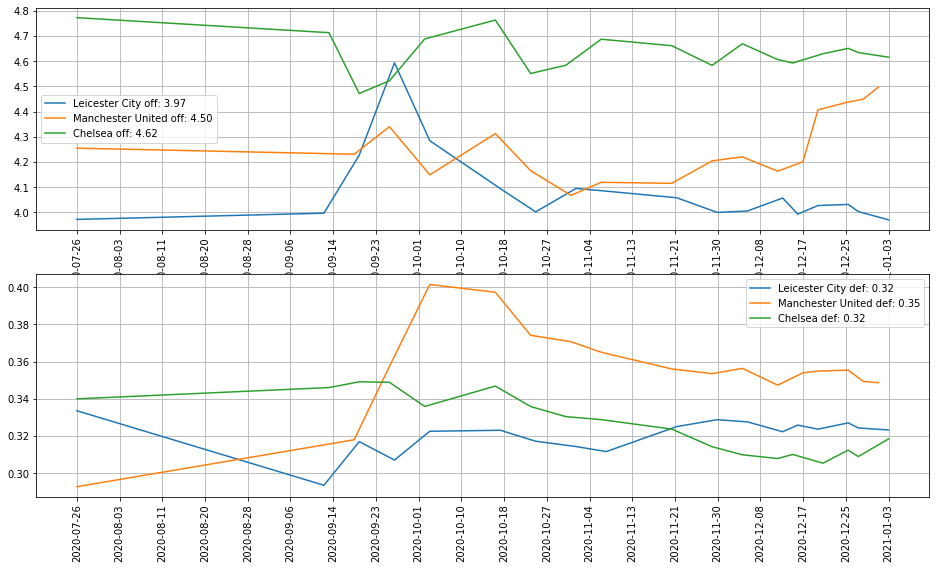

In [17]:
ax=None
for team in calib.teams.values():
    if team.name in ['Manchester United','Leicester City','Chelsea']:
    #if team.name in ['BPLHome','BPLAway']:
        ax=team.plt(ax=ax)
        #ax[0].axvline(x=37)
        #ax[1].axvline(x=37)


In [18]:
df=pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv')
df=df.set_index('name')
df = df.join(sr).reset_index()[['name','off','def','Off','Deff']].dropna()
df.head(10)

,name,off,def,Off,Deff
0,Manchester City,2.89,0.20,5.62,0.25
3,Liverpool,2.64,0.41,5.49,0.30
6,Chelsea,2.44,0.46,4.62,0.32
9,Manchester United,2.52,0.57,4.50,0.35
15,Tottenham Hotspur,2.26,0.56,4.24,0.35
19,Arsenal,2.17,0.55,3.69,0.33
22,Leicester City,2.13,0.59,3.97,0.32
23,Aston Villa,2.19,0.66,4.28,0.36
30,West Ham United,2.00,0.67,3.77,0.37
32,Southampton,1.88,0.62,3.38,0.36


array([ 2.16818531, -0.60301395])

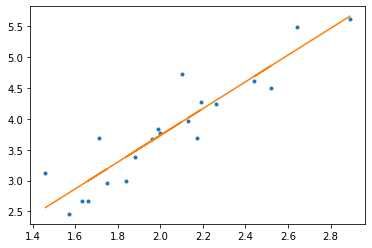

In [19]:
plt.plot(df['off'],df['Off'],'.')
poly = np.polyfit(df['off'],df['Off'],1)
plt.plot(df['off'],np.polyval(poly,df['off']))
poly

array([0.27255892, 0.1847069 ])

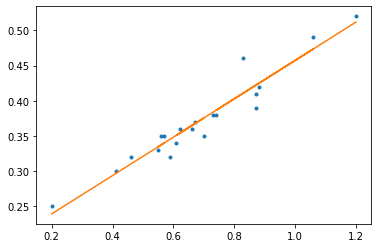

In [20]:
plt.plot(df['def'],df['Deff'],'.')
poly = np.polyfit(df['def'],df['Deff'],1)
plt.plot(df['def'],np.polyval(poly,df['def']))
poly

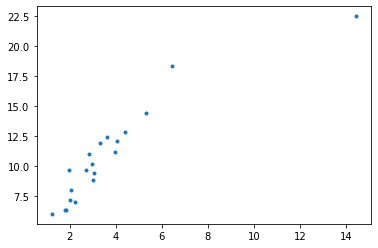

In [21]:
plt.plot(df['off']/df['def'],df['Off']/df['Deff'],'.')